In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [35]:
df = pd.read_csv('/content/sample_data/preprocessed_data.csv', index_col='valid_time')
df.head()

,hour,dayofweek,month,quarter,year,wind_speed,wind_dir,surface_pressure,precipitation,land_temp
valid_time,,,,,,,,,,
2000-01-01 00:00:00,0,5,1,1,2000,2.602381,335.013123,100019.430,0.000000,11.77096
2000-01-01 01:00:00,1,5,1,1,2000,2.501312,340.668849,100003.090,0.000477,11.87667
2000-01-01 02:00:00,2,5,1,1,2000,2.402476,341.386454,99985.484,0.007153,12.37856
2000-01-01 03:00:00,3,5,1,1,2000,2.811762,337.551386,100010.266,0.034809,13.01086
2000-01-01 04:00:00,4,5,1,1,2000,3.127635,334.745659,100062.050,0.016212,13.38143


In [36]:
df.index = pd.to_datetime(df.index)

In [37]:
# 80, 20 split
train_df = df[df.index < '2020-01-01']
test_df = df[df.index >= '2020-01-01']

In [38]:
df.columns

Index(['hour', 'dayofweek', 'month', 'quarter', 'year', 'wind_speed',
       'wind_dir', 'surface_pressure', 'precipitation', 'land_temp'],
      dtype='object')

In [39]:
FEATURES = ['hour', 'dayofweek', 'month', 'quarter', 'year', 'wind_speed', 'wind_dir', 'surface_pressure', 'precipitation']
TARGET = 'land_temp'

def create_xy(df):
    return df[FEATURES], df[TARGET].values

X_train, y_train = create_xy(train_df)
X_test, y_test = create_xy(test_df)

In [40]:
def print_metrics(y_true, preds):
    mae = mean_absolute_error(y_true, preds)
    mse = mean_squared_error(y_true, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, preds)
    print('MAE:', "{:4f}".format(mae))
    print('RMSE:', "{:.4f}".format(rmse))
    print('R2:', "{:.4f}".format(r2), '\n')

def cv_evaluate(model):
    # Check CV Scores
    scores = cross_val_score(model, X_train, y_train, cv=3)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    print('Cross Validation Scores:')
    print(f'CV_scores = {scores}')
    print('CV mean:', "{:.4f}".format(np.mean(scores)))
    print('CV Std:', "{:.4f}".format(np.std(scores)), '\n')

    # print Accuracy Scores
    print("Train Scores:")
    print_metrics(y_train, train_preds)
    print("Test Scores:")
    print_metrics(y_test, test_preds)

## Linear Regression

In [41]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
cv_evaluate(lr_model)

Cross Validation Scores:
CV_scores = [0.56940754 0.57053668 0.56450568]
CV mean: 0.5681
CV Std: 0.0026 

Train Scores:
MAE: 3.921383
RMSE: 4.9243
R2: 0.5738 

Test Scores:
MAE: 3.769433
RMSE: 4.7391
R2: 0.6034 



In [42]:
xgb_model = xgb.XGBRegressor(
    learning_rate=0.01,
    n_estimators=200,
    max_depth=3,
    min_child_weight=3,
    gamma=10,
    subsample = 0.8,
    colsample_bytree = 0.4,
    reg_alpha=0
)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=10, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [43]:
cv_evaluate(xgb_model)

Cross Validation Scores:
CV_scores = [0.7570165  0.76380309 0.75078694]
CV mean: 0.7572
CV Std: 0.0053 

Train Scores:
MAE: 2.930350
RMSE: 3.6722
R2: 0.7630 

Test Scores:
MAE: 2.852196
RMSE: 3.6100
R2: 0.7698 



In [44]:
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [45]:
cv_evaluate(rf_model)

Cross Validation Scores:
CV_scores = [0.91972948 0.91827242 0.90945126]
CV mean: 0.9158
CV Std: 0.0045 

Train Scores:
MAE: 0.402733
RMSE: 0.5545
R2: 0.9946 

Test Scores:
MAE: 1.701720
RMSE: 2.2502
R2: 0.9106 



In [46]:
models_dict = {
    'Linear Regression': lr_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
}

metrics_dict = {}
for name, model in models_dict.items():
    preds = model.predict(X_test)

    score = model.score(X_test, y_test)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)

    metrics_dict[name] = np.array([score, mae, np.sqrt(mse)])

metrics_df = pd.DataFrame(metrics_dict, index=['score', 'MAE', 'RMSE'])

In [47]:
metrics_df

,Linear Regression,Random Forest,XGBoost
score,0.603361,0.910578,0.769842
MAE,3.769433,1.701720,2.852196
RMSE,4.739113,2.250204,3.610044


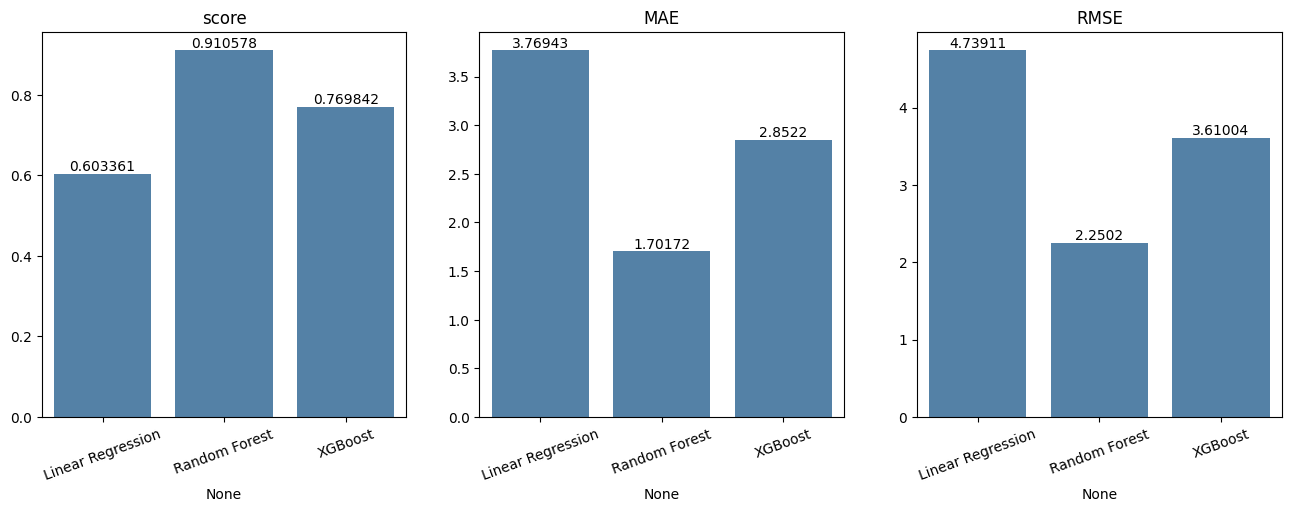

In [48]:
plt.figure(figsize=(16,5))
for i, col in enumerate(['score', 'MAE', 'RMSE']):
    plt.subplot(1, 3, i+1)
    ax = sns.barplot(data=metrics_df.T, x=metrics_df.T.index, y=col, color='steelblue')
    ax.bar_label(ax.containers[0], fontsize=10)
    ax.set_title(f'{col}')
    plt.ylabel('')
    plt.xticks(rotation=20.2)

plt.show()

## Conclusion
- Obviously the best model score is Random Forest with score above 91%.
- The lowest MAE and RMSE is Random Forest.
- Therefor, selected model is Random Forest model.

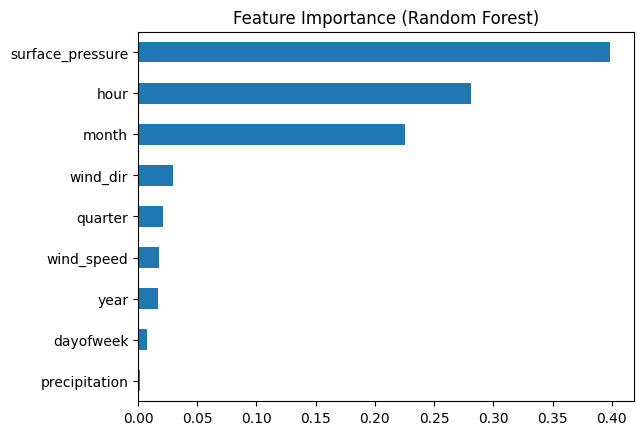

In [49]:
pd.DataFrame(rf_model.feature_importances_, index=FEATURES).sort_values(by=0).plot(kind='barh', title='Feature Importance (Random Forest)')
plt.legend().remove()
plt.show()

<ipython-input-50-a839fc9aa03a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] = rf_model.predict(X_test)


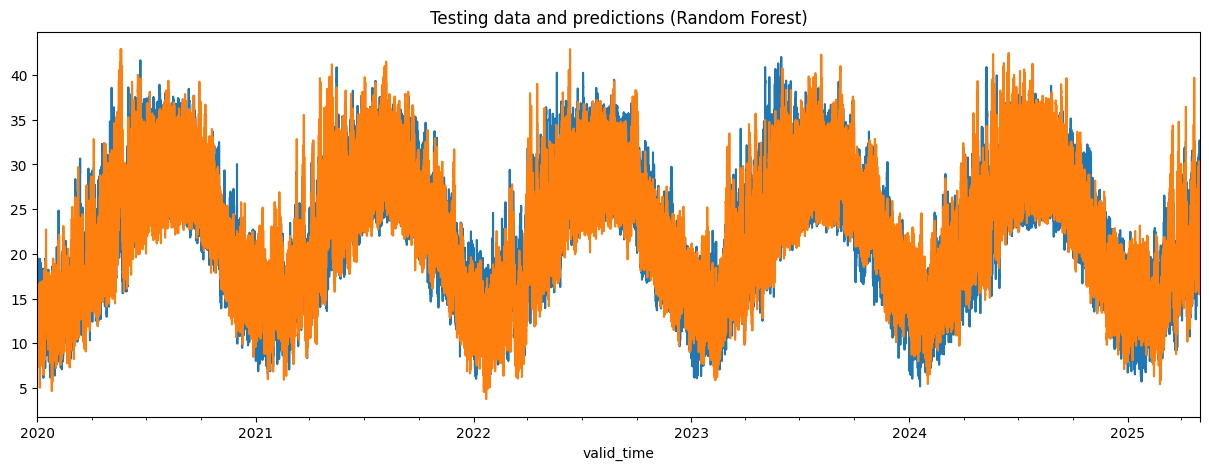

In [50]:
test_df['pred'] = rf_model.predict(X_test)

test_df['pred'].plot(figsize=(15, 5))
test_df['land_temp'].plot(title='Testing data and predictions (Random Forest)')
plt.show()

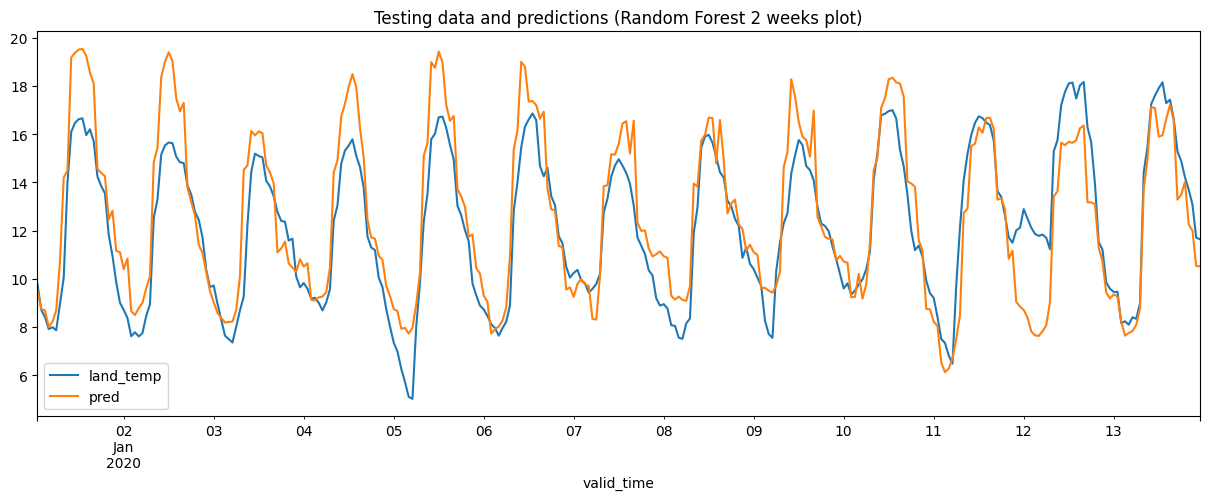

In [51]:
rand_2_weeks = test_df[(test_df.index > '2020-01-01') & (test_df.index < '2020-01-14')]
rand_2_weeks['land_temp'].plot(title='Testing data and predictions (Random Forest 2 weeks plot)')
rand_2_weeks['pred'].plot(figsize=(15, 5))
plt.legend()
plt.show()

## Random Forest Hyper Parameters Tuning

In [54]:
param_grid = [{
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    }]

In [55]:
model = RandomForestRegressor()
gridModel_1 = GridSearchCV(model, param_grid=param_grid, cv=3, n_jobs=-1,)
gridModel_1.fit(X_train, y_train)
gridModel_1.best_params_, gridModel_1.best_score_

({'max_depth': 10,
  'max_features': 'sqrt',
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'n_estimators': 100},
 np.float64(0.9057919092208153))

In [56]:
model = gridModel_1.best_estimator_

In [57]:
cv_evaluate(model)

Cross Validation Scores:
CV_scores = [0.90736958 0.90979537 0.89627956]
CV mean: 0.9045
CV Std: 0.0059 

Train Scores:
MAE: 1.605813
RMSE: 2.1067
R2: 0.9220 

Test Scores:
MAE: 1.752009
RMSE: 2.2932
R2: 0.9071 



<ipython-input-58-0c01bbb65275>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['tuned_pred'] = model.predict(X_test)


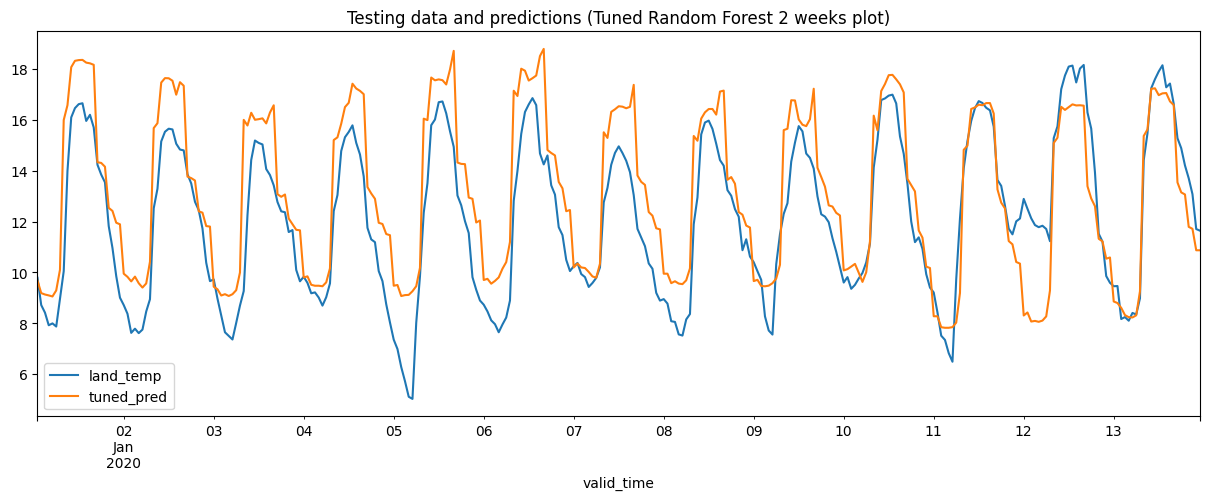

In [58]:
test_df['tuned_pred'] = model.predict(X_test)

rand_2_weeks = test_df[(test_df.index > '2020-01-01') & (test_df.index < '2020-01-14')]
rand_2_weeks['land_temp'].plot(title='Testing data and predictions (Tuned Random Forest 2 weeks plot)')
rand_2_weeks['tuned_pred'].plot(figsize=(15, 5))
plt.legend()
plt.show()